# Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
from glob import glob
import imageio
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt
import scipy as sc

# Data Preprocessing

In [2]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00278/SEMG_DB1.rar

File ‘SEMG_DB1.rar’ already there; not retrieving.



In [3]:
!unrar e  SEMG_DB1.rar


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from SEMG_DB1.rar


Would you like to replace the existing file 10Amar.log
275168 bytes, modified on 2013-04-27 11:09
with a new one
275168 bytes, modified on 2013-04-27 11:09

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit E

Extracting  10Amar.txt                                                    23% 24%  OK 
Extracting  10Apie.txt                                                    24% 25%  OK 
Extracting  10Asen.txt                                                    25% 26%  OK 
Extracting  11Amar.txt                                                    26% 27%  OK 
Extracting  11Apie.txt                                                    27% 28%  OK 
Extracting  11Asen.txt                                                    28% 29%  OK 
Extracting  1Amar.txt                                                     30% 

In [4]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [5]:
!mkdir data/A
!mkdir data/N

mkdir: cannot create directory ‘data/A’: File exists
mkdir: cannot create directory ‘data/N’: File exists


In [6]:
!mv [1-9]A*.txt data/A
!mv [1-9]N*.txt data/N

In [7]:
!mv 1[0-9]A*.txt data/A
!mv 1[0-9]N*.txt data/N

In [8]:
!ls data/A

10Amar.txt  11Asen.txt	2Apie.txt  4Amar.txt  5Asen.txt  7Apie.txt  9Amar.txt
10Apie.txt  1Amar.txt	2Asen.txt  4Apie.txt  6Amar.txt  7Asen.txt  9Apie.txt
10Asen.txt  1Apie.txt	3Amar.txt  4Asen.txt  6Apie.txt  8Amar.txt  9Asen.txt
11Amar.txt  1Asen.txt	3Apie.txt  5Amar.txt  6Asen.txt  8Apie.txt
11Apie.txt  2Amar.txt	3Asen.txt  5Apie.txt  7Amar.txt  8Asen.txt


In [9]:
!ls data/N

10Nmar.txt  11Nsen.txt	2Npie.txt  4Nmar.txt  5Nsen.txt  7Npie.txt  9Nmar.txt
10Npie.txt  1Nmar.txt	2Nsen.txt  4Npie.txt  6Nmar.txt  7Nsen.txt  9Npie.txt
10Nsen.txt  1Npie.txt	3Nmar.txt  4Nsen.txt  6Npie.txt  8Nmar.txt  9Nsen.txt
11Nmar.txt  1Nsen.txt	3Npie.txt  5Nmar.txt  6Nsen.txt  8Npie.txt
11Npie.txt  2Nmar.txt	3Nsen.txt  5Npie.txt  7Nmar.txt  8Nsen.txt


In [10]:
def read_folder(path): 
  folder_con = []
  file_name = []
  n = 1
  for file in os.listdir(path):
      if file.endswith(".txt"):
          file_path = f"{path}/{file}"
          df = pd.read_csv(file_path, sep='\t', skiprows=list(range(7)), header=None).dropna()
          
          if len(df.columns) == 6:
            df.drop(columns=df.columns[-2:], axis=1, inplace=True)
          if len(df.columns) == 5:
            df.drop(columns=df.columns[-1:], axis=1, inplace=True)
          
          folder_con.append(df)
          file_name.append(file_path)
          n = n + 1
          
  return folder_con, file_name

In [11]:
A_folder_con, A_name = read_folder('data/A')
N_folder_con, N_name = read_folder('data/N')

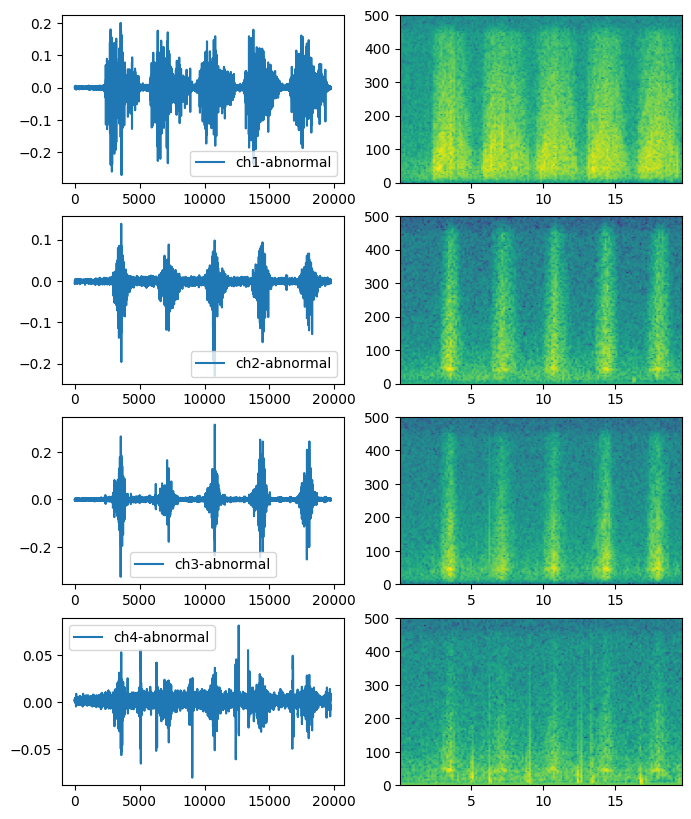

In [12]:
sampling_frequency = 1e3
plt.figure(figsize=(8,10))
plt.subplot(421)
plt.plot(A_folder_con[0].iloc[:,0],label='ch1-abnormal')
plt.legend()
plt.subplot(422)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(A_folder_con[0].iloc[:,0],Fs=sampling_frequency)


plt.subplot(423)
plt.plot(A_folder_con[0].iloc[:,1],label='ch2-abnormal')
plt.legend()
plt.subplot(424)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(A_folder_con[0].iloc[:,1],Fs=sampling_frequency)


plt.subplot(425)
plt.plot(A_folder_con[0].iloc[:,2],label='ch3-abnormal')
plt.legend()
plt.subplot(426)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(A_folder_con[0].iloc[:,2],Fs=sampling_frequency)



plt.subplot(427)
plt.plot(A_folder_con[0].iloc[:,3],label='ch4-abnormal')
plt.legend()
plt.subplot(428)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(A_folder_con[0].iloc[:,3],Fs=sampling_frequency)

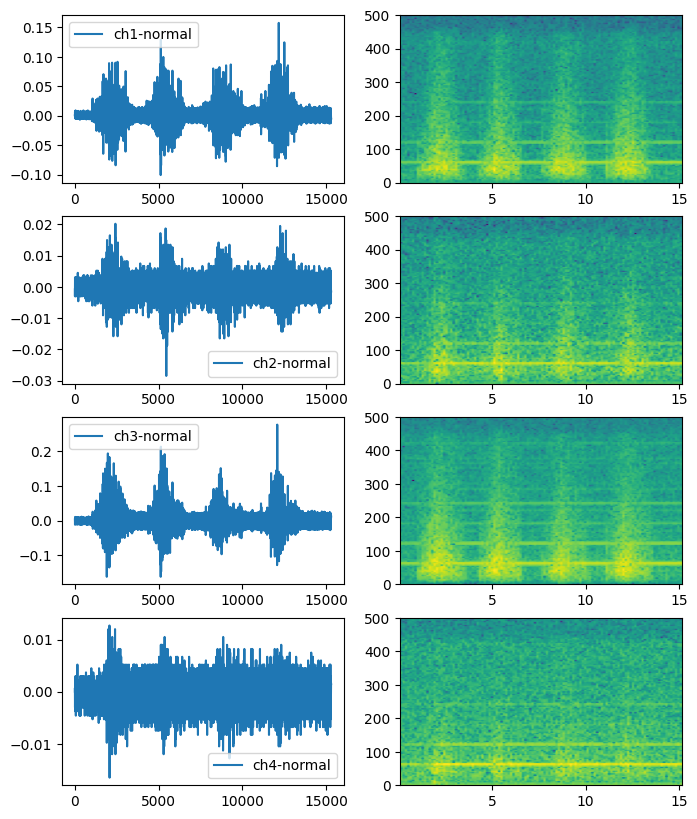

In [13]:
sampling_frequency = 1e3
plt.figure(figsize=(8,10))
plt.subplot(421)
plt.plot(N_folder_con[0].iloc[:,0],label='ch1-normal')
plt.legend()
plt.subplot(422)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(N_folder_con[0].iloc[:,0],Fs=sampling_frequency)


plt.subplot(423)
plt.plot(N_folder_con[0].iloc[:,1],label='ch2-normal')
plt.legend()
plt.subplot(424)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(N_folder_con[0].iloc[:,1],Fs=sampling_frequency)


plt.subplot(425)
plt.plot(N_folder_con[0].iloc[:,2],label='ch3-normal')
plt.legend()
plt.subplot(426)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(N_folder_con[0].iloc[:,2],Fs=sampling_frequency)



plt.subplot(427)
plt.plot(N_folder_con[0].iloc[:,3],label='ch4-normal')
plt.legend()
plt.subplot(428)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(N_folder_con[0].iloc[:,3],Fs=sampling_frequency)

In [14]:
def butter_lowpass(df, sampling, cut_off=40, order=2):
    
    for index in range(df.shape[1]):
        sig = df.iloc[:, index].values   
        sos = signal.butter(order, cut_off, 'lp', fs=sampling, output='sos') # ButterWorth lowpass filter
        filtered = signal.sosfilt(sos, sig)  
        df.loc[:, index] = filtered

Text(0.5, 1.0, 'Filtered')

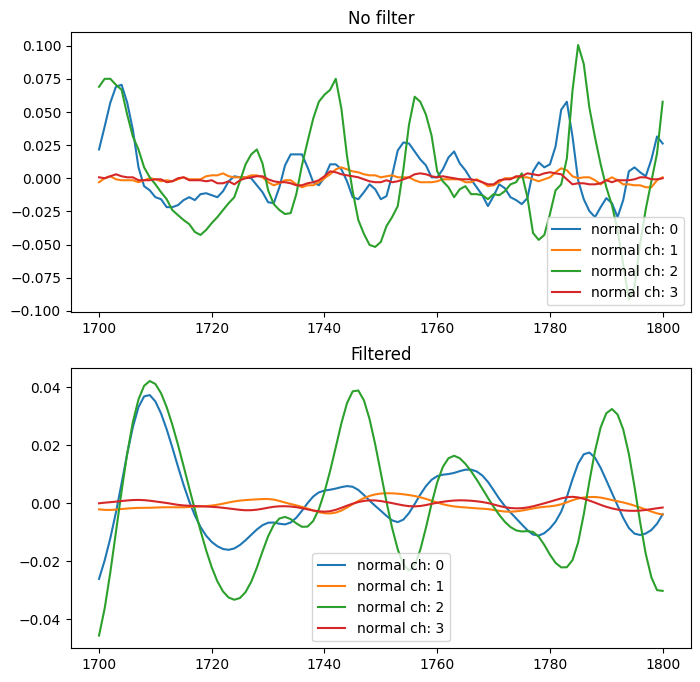

In [15]:
plt.figure(figsize=(8,8))
plt.subplot(211)
for index in range(N_folder_con[0].shape[1]):
    plt.plot(N_folder_con[0].loc[1700:1800, index], label='normal ch: '+str(index))
    
plt.legend()
plt.title('No filter')

butter_lowpass(N_folder_con[0], 1000, 40, 2)

plt.subplot(212)
for index in range(N_folder_con[0].shape[1]):
    plt.plot(N_folder_con[0].loc[1700:1800, index], label='normal ch: '+str(index))
    
plt.legend()
plt.title('Filtered')

In [16]:
A_final_data = pd.concat(A_folder_con, ignore_index=True)
N_final_data = pd.concat(N_folder_con, ignore_index=True)
A_torch_data = torch.tensor(A_final_data.values)
N_torch_data = torch.tensor(N_final_data.values)

In [17]:
def image_creator(data, label, wid_len=256, stride=128):
  i = 0
  num = 0
  img_list = []
  while True:
    img = data[i: i+wid_len]
    i = i + stride
    num = num + 1 
    new = []
    new.append(img.reshape(1, wid_len, 4))
    new.append(label)
    img_list.append(new)
    if num == int(((len(data) - wid_len) / stride + 1)):
      break
  return img_list
  

In [18]:
N_list = image_creator(N_torch_data, label=0, wid_len=256, stride=128)
A_list = image_creator(A_torch_data, label=1, wid_len=256, stride=128)
data = A_list + N_list

In [19]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data_frame = data
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.data_frame[idx][0]
        label = self.data_frame[idx][1]
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [20]:
plt.imshow(data[0][0].squeeze(), cmap="gray")
plt.axis(False)
plt.show()

In [21]:
train, test = train_test_split(data, test_size=0.33, shuffle=True)

In [22]:
train_dataset = MyDataset(train)
test_dataset = MyDataset(test)


# Data loader
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


# Network Implementation

In [23]:
class My_Net(nn.Module):
  def __init__(self, K=2):
    super(My_Net, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), stride=1),
        )
    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), stride=(1, 1)),
        nn.Dropout2d(p=0.2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), stride=(1, 1)),
        nn.Dropout2d(p=0.2)
    )

    self.fc1 = nn.Sequential(
        nn.Linear(256 * 253 * 1, K),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(-1, 256 * 253 * 1)
    x = self.fc1(x)
    return x

  

In [24]:
model = My_Net(K=2)


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
model.double()

cuda:0


My_Net(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=64768, out_features=2, bias=True)
    (1): Sigmoid()
  )
)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [27]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  train_accs = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  test_accs = np.zeros(epochs)

  for it in range(epochs):
    n_correct = 0.
    n_total = 0.
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
      _, predictions = torch.max(outputs, 1)
      n_correct += (predictions == targets).sum().item()
      n_total += targets.shape[0]

    train_acc = n_correct / n_total
    train_loss = np.mean(train_loss)

    model.eval()
    with torch.no_grad():
      test_loss = []
      n_correct = 0.
      n_total = 0.
      for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
        _, predictions = torch.max(outputs, 1)
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

      test_loss = np.mean(test_loss)
      test_acc = n_correct / n_total

      train_losses[it] = train_loss
      test_losses[it] = test_loss
      train_accs[it] = train_acc
      test_accs[it] = test_acc


      dt = datetime.now() - t0
      print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration:{dt}")

  return train_losses, test_losses, train_accs, test_accs



# Model Train and Results

In [28]:
train_losses, test_losses, train_accs, test_accs = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=10
)

Epoch 1/10, Train Loss: 0.6407,       Test Loss: 0.6351, Duration:0:01:12.984019
Epoch 2/10, Train Loss: 0.6287,       Test Loss: 0.6291, Duration:0:01:09.706811
Epoch 3/10, Train Loss: 0.6238,       Test Loss: 0.6258, Duration:0:01:09.879629
Epoch 4/10, Train Loss: 0.6205,       Test Loss: 0.6266, Duration:0:01:10.149813
Epoch 5/10, Train Loss: 0.6186,       Test Loss: 0.6221, Duration:0:01:09.997035
Epoch 6/10, Train Loss: 0.6133,       Test Loss: 0.6192, Duration:0:01:09.966584
Epoch 7/10, Train Loss: 0.6132,       Test Loss: 0.6230, Duration:0:01:09.998171
Epoch 8/10, Train Loss: 0.6095,       Test Loss: 0.6195, Duration:0:01:10.020191
Epoch 9/10, Train Loss: 0.6045,       Test Loss: 0.6080, Duration:0:01:09.951410
Epoch 10/10, Train Loss: 0.6072,       Test Loss: 0.5970, Duration:0:01:10.044856


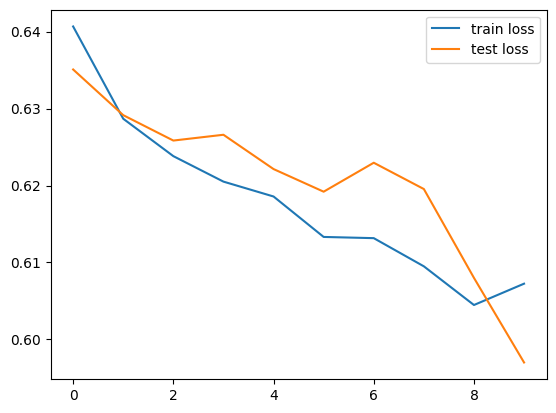

In [29]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [30]:
model.eval()
with torch.no_grad():
  n_correct = 0.
  n_total = 0.
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

  train_acc = n_correct / n_total

  n_correct = 0.
  n_total = 0.
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

  test_acc = n_correct / n_total
  print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.6905, Test acc: 0.6783


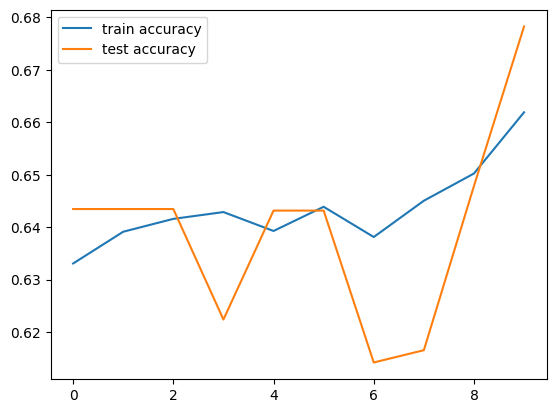

In [31]:
plt.plot(train_accs, label='train accuracy')
plt.plot(test_accs, label='test accuracy')
plt.legend()
plt.show()